# Diafiltration DoE Paper Plots

Xinhong Liu
  
## Import library

In [1]:
import numpy as np
import scipy.io as spio
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib as mpl
from matplotlib.lines import Line2D
from matplotlib import patheffects
import pandas as pd

In [2]:
def loadmat(filename):
    '''
    Read in nested structure(mat file) generated from MATLAB and output dictionaries.

    This function is called instead of using spio.loadmat directly as it cures the problem of not properly recovering python dictionaries
    from mat files. It calls the function check keys to cure all entries which are still mat-objects.
    Adapted from https://stackoverflow.com/questions/7008608/scipy-io-loadmat-nested-structures-i-e-dictionaries
    '''
    def _check_keys(d):
        '''
        checks if entries in dictionary are mat-objects. If yes
        todict is called to change them to nested dictionaries
        '''
        for key in d:
            if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
                d[key] = _todict(d[key])
            elif isinstance(d[key], np.ndarray):
                d[key] = _tolist(d[key])

        return d

    def _todict(matobj):
        '''
        A recursive function which constructs from matobjects nested dictionaries
        '''
        d = {}
        for strg in matobj._fieldnames:
            elem = matobj.__dict__[strg]
            if isinstance(elem, spio.matlab.mio5_params.mat_struct):
                d[strg] = _todict(elem)
            elif isinstance(elem, np.ndarray):
                d[strg] = _tolist(elem)
            else:
                d[strg] = elem
        return d

    def _tolist(ndarray):
        '''
        A recursive function which constructs lists from cellarrays
        (which are loaded as numpy ndarrays), recursing into the elements
        if they contain matobjects.
        '''
        elem_list = []
        for sub_elem in ndarray:
            if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):
                elem_list.append(_todict(sub_elem))
            elif isinstance(sub_elem, np.ndarray):
                elem_list.append(_tolist(sub_elem))
            else:
                elem_list.append(sub_elem)
        return elem_list
    data = spio.loadmat(filename, struct_as_record=False, squeeze_me=True)
    return _check_keys(data)

In [3]:
def plot_heatmap_doe_FIM(data_stru, heatmap_doe_stru, Vmin, Vmax, Level, Colorbar_ticks, Manual_locations, name_append, filled=False, Jw_filter=True, bar=False):
    '''
    Plot contours for sigma sensitivity (difference in predictions) over different experiment conditions.

    '''
    diaf_mode = False
    if 'cf0' in heatmap_doe_stru:
        x = heatmap_doe_stru['cf0']
        xlabelstr = '$\mathbf{c_f}$(t=0) [mM]'
    else:
        x = heatmap_doe_stru['cd']
        xlabelstr = '$\mathbf{c_d}$ [mM]'
        diaf_mode = True
    y = heatmap_doe_stru['delp']
    ylabelstr = '$\mathbf{\Delta}$P [psi]'

    X,Y = np.meshgrid(x, y)
    axfontsize = 16

    # gas constant
    R = 8.314e-5 #[cm^3 bar / micromol / K]
    # temperature
    T = data_stru['data_config']['Temp'] #[K]
    # number of dissolved species
    ni = data_stru['data_config']['ni']

    if not diaf_mode:
        # Jw0 = delp - sigma * niRT * cf0
        Jw0 = Y/14.504 - 1*ni*R*T*X
        jw0 = 1*ni*R*T*np.array(x)*14.504
    else:
        cf0 = 5
        Jw0 = Y/14.504 - 1*ni*R*T*cf0
        jw0 = 1*ni*R*T*cf0*14.504

    def patch_back():
        ax = plt.gca()
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        xy = (xmin,ymin)
        width = xmax - xmin
        height = ymax - ymin

        # create the patch and place it in the back of countourf (zorder!)
        p = patches.Rectangle(xy, width, height, color ='gray', zorder=-10)
        ax.add_patch(p)

    # A optimality
    fig = plt.figure(1,figsize=(4,4))
    Z = np.log10(heatmap_doe_stru['trace'])
    if filled:
        plt.contourf(X,Y,Z,50,cmap='spring', vmin=Vmin[0], vmax=Vmax[0])
        cp = plt.contour(X,Y,Z,Level[0],linewidths=3,colors ='k')
    else:
        cp = plt.contour(X,Y,Z,Level[0],linewidths=2)
    manual_locations = Manual_locations[0]
    plt.clabel(cp,inline=True,manual=manual_locations,
               fontsize=15,colors ='k',fmt='%1.1f',zorder=2)

    if filled:
        if Jw_filter:
            patch_back()
        else:
            plt.fill_between(x, y[0], jw0, color='gray', zorder=2)
    else:
        cg = plt.contour(X, Y, Jw0, [0], colors='orangered')
        plt.setp(cg.collections,
                 path_effects=[patheffects.withTickedStroke(angle=300, length=2)])

    plt.xlabel(xlabelstr,fontsize=axfontsize,fontweight='bold')
    plt.ylabel(ylabelstr,fontsize=axfontsize,fontweight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(bottom= y[0])
    fig.savefig('heatmap_doe'+name_append+'-A.png',dpi=300,bbox_inches='tight')

    # D optimality
    fig = plt.figure(2,figsize=(4,4))
    Z = np.log10(heatmap_doe_stru['determinant'])
    if filled:
        plt.contourf(X,Y,Z,100,cmap='spring', vmin=Vmin[1], vmax=Vmax[1])
        cp = plt.contour(X,Y,Z,Level[1],linewidths=3,colors ='k')
    else:
        cp = plt.contour(X,Y,Z,Level[1],linewidths=2)
    manual_locations = Manual_locations[1]
    plt.clabel(cp,inline=True,manual=manual_locations,
               fontsize=15,colors ='k',fmt='%1.1f',zorder=2)

    if filled:
        if Jw_filter:
            patch_back()
        else:
            plt.fill_between(x, y[0], jw0, color='gray', zorder=2)
    else:
        cg = plt.contour(X, Y, Jw0, [0], colors='orangered')
        plt.setp(cg.collections,
                 path_effects=[patheffects.withTickedStroke(angle=300, length=2)])

    plt.xlabel(xlabelstr,fontsize=axfontsize,fontweight='bold')
    plt.ylabel(ylabelstr,fontsize=axfontsize,fontweight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(bottom= y[0])
    fig.savefig('heatmap_doe'+name_append+'-D.png',dpi=300,bbox_inches='tight')

    # E optimality
    fig = plt.figure(3,figsize=(4,4))
    Z = np.log10(heatmap_doe_stru['min_eig'])
    if filled:
        plt.contourf(X,Y,Z,50,cmap='spring', vmin=Vmin[2], vmax=Vmax[2])
        cp = plt.contour(X,Y,Z,Level[2],linewidths=3,colors ='k')
    else:
        cp = plt.contour(X,Y,Z,Level[2],linewidths=2)
    manual_locations = Manual_locations[2]
    plt.clabel(cp,inline=True,manual=manual_locations,
               fontsize=15,colors ='k',fmt='%1.1f',zorder=2)

    if filled:
        if Jw_filter:
            patch_back()
        else:
            plt.fill_between(x, y[0], jw0, color='gray', zorder=2)
    else:
        cg = plt.contour(X, Y, Jw0, [0], colors='orangered')
        plt.setp(cg.collections,
                 path_effects=[patheffects.withTickedStroke(angle=300, length=2)])

    plt.xlabel(xlabelstr,fontsize=axfontsize,fontweight='bold')
    plt.ylabel(ylabelstr,fontsize=axfontsize,fontweight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(bottom= y[0])
    fig.savefig('heatmap_doe'+name_append+'-E.png',dpi=300,bbox_inches='tight')
    
    # ME optimality
    fig = plt.figure(4,figsize=(4,4))
    Z = np.log10(heatmap_doe_stru['cond'])
    if filled:
        plt.contourf(X,Y,Z,50,cmap='spring_r', vmin=Vmin[3], vmax=Vmax[3])
        cp = plt.contour(X,Y,Z,Level[3],linewidths=3,colors ='k')
    else:
        cp = plt.contour(X,Y,Z,Level[3],linewidths=2)
    manual_locations = Manual_locations[3]
    plt.clabel(cp,inline=True,manual=manual_locations,
               fontsize=15,colors ='k',fmt='%1.1f',zorder=2)

    if filled:
        if Jw_filter:
            patch_back()
        else:
            plt.fill_between(x, y[0], jw0, color='gray', zorder=2)
    else:
        cg = plt.contour(X, Y, Jw0, [0], colors='orangered')
        plt.setp(cg.collections,
                 path_effects=[patheffects.withTickedStroke(angle=300, length=2)])

    plt.xlabel(xlabelstr,fontsize=axfontsize,fontweight='bold')
    plt.ylabel(ylabelstr,fontsize=axfontsize,fontweight='bold')
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylim(bottom= y[0])
    fig.savefig('heatmap_doe'+name_append+'-ME.png',dpi=300,bbox_inches='tight')

    # uniform colorbar
    if filled & bar:
        for i in range(len(Vmin)):
            if i>2:
                cmap = mpl.cm.spring_r
            else:
                cmap = mpl.cm.spring
            norm = mpl.colors.Normalize(vmin=Vmin[i], vmax=Vmax[i])
            # horizontal
            fig, ax = plt.subplots(figsize=(4, 1))
            fig.subplots_adjust(bottom=0.5)
            cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                            norm=norm,
                                            orientation='horizontal',
                                            ticks=Colorbar_ticks[i],
                                            extend='max')
            ax.tick_params(labelsize = 15)
            fig.savefig('colorbar'+str(i)+name_append+'-horizontal.png',dpi=300,bbox_inches='tight')
            #vertical
            fig, ax = plt.subplots(figsize=(1, 4))
            fig.subplots_adjust(left=0.5)
            cb1 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                            norm=norm,
                                            orientation='vertical',
                                            ticks=Colorbar_ticks[i],
                                            extend='max')
            ax.tick_params(labelsize = 15)
            fig.savefig('colorbar'+str(i)+name_append+'-vertical.png',dpi=300,bbox_inches='tight')

## Generate plots

In [4]:
heatmap_doe_stru = loadmat('data\\heatmap_doe-dat501.1.mat')['heatmap_doe']
heatmap_doe_stru1 = loadmat('data\\heatmap_doe-dat511.12-endvial1.mat')['heatmap_doe']
heatmap_doe_stru10 = loadmat('data\\heatmap_doe-dat511.12-endvial10.mat')['heatmap_doe']
print(np.log10(min(min(heatmap_doe_stru['trace']))))
print(np.log10(max(max(heatmap_doe_stru['trace']))))
print(np.log10(min(min(heatmap_doe_stru1['trace']))))
print(np.log10(max(max(heatmap_doe_stru10['trace']))),'\n')

print(np.log10(min(min(heatmap_doe_stru['determinant']))))
print(np.log10(max(max(heatmap_doe_stru['determinant']))))
print(np.log10(min(min(heatmap_doe_stru1['determinant']))))
print(np.log10(max(max(heatmap_doe_stru10['determinant']))),'\n')

print(np.log10(min(min(heatmap_doe_stru['min_eig']))))
print(np.log10(max(max(heatmap_doe_stru['min_eig']))))
print(np.log10(min(min(heatmap_doe_stru1['min_eig']))))
print(np.log10(max(max(heatmap_doe_stru10['min_eig']))),'\n')

print(np.log10(min(min(heatmap_doe_stru['cond']))))
print(np.log10(max(max(heatmap_doe_stru['cond']))))
print(np.log10(max(max(heatmap_doe_stru1['cond']))))
print(np.log10(min(min(heatmap_doe_stru10['cond']))))

C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:15: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:29: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:45: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):


7.133737808064669
10.48772187732801
8.113106622878597
12.580601110238833 

14.347556756399563
26.836617856712568
15.733038333023684
31.309929944779867 

1.16071398026929
7.554300955256779
2.2888071463759285
8.89889289590789 

2.2359846069735685
5.931661216661674
6.024709900951452
2.9168172520241415


### Filtration
#### M1(conctration polarization, continuous retentate)

#### Functions of FIM on different experimental conditions

C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:15: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:29: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:45: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):


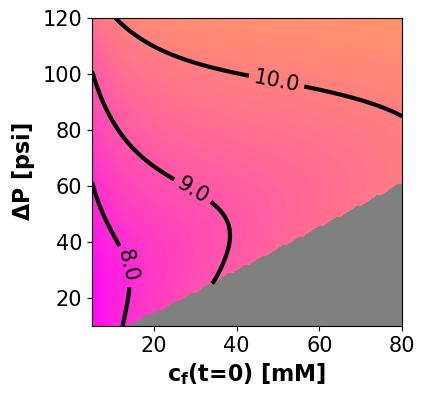

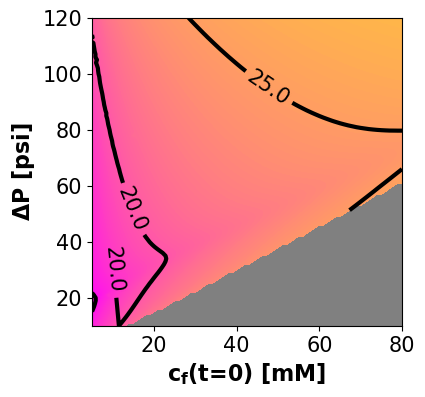

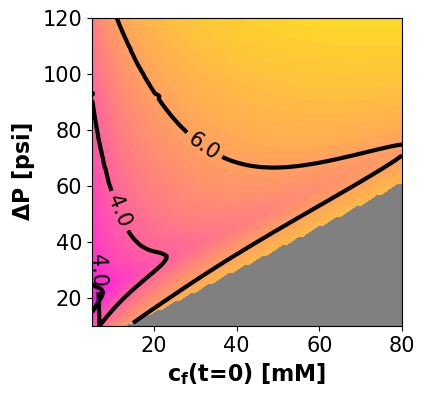

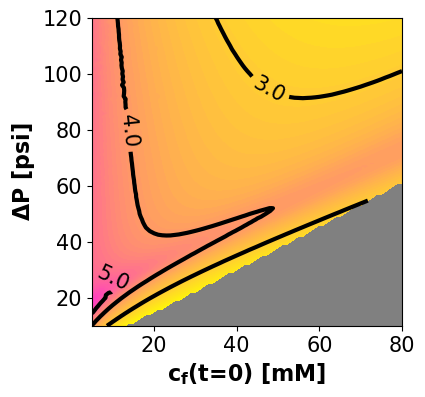

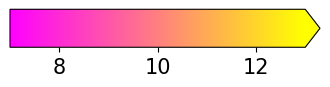

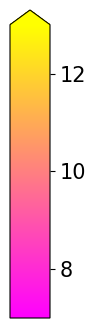

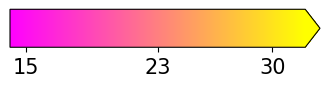

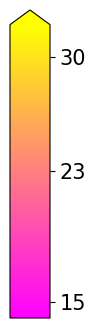

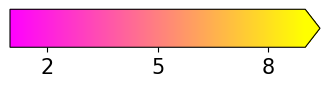

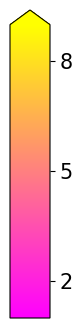

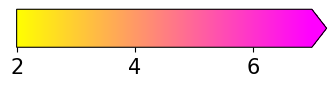

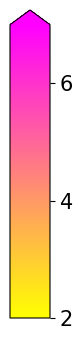

In [5]:
data_stru_f = loadmat('data\\data_stru-dataset501.1.mat')['data_stru']
heatmap_doe_stru = loadmat('data\\heatmap_doe-dat501.1.mat')['heatmap_doe']

Vmin = [7,14,1,2]
Vmax = [13,32,9,7]
Level = [[8,9,10],
         [15,20,25],
         [2,4,6],
         [3,4,5]]
Manual_locations = [[(10,30),(30,60),(50,100)],
                   [(10,30),(30,60),(50,100)],
                   [(10,30),(10,50),(30,70)],
                   [(10,30),(15,80),(50,100)]]
Colorbar_ticks = [[8, 10, 12],
                  [15, 23, 30],
                  [2, 5, 8],
                  [2, 4, 6]]
                  
name_append = ''
plot_heatmap_doe_FIM(data_stru_f, heatmap_doe_stru, Vmin, Vmax, Level, Colorbar_ticks, Manual_locations, name_append, filled =True, bar=True)

### Diafiltration
#### M1(conctration polarization, continuous retentate)

C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:15: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:29: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:45: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):


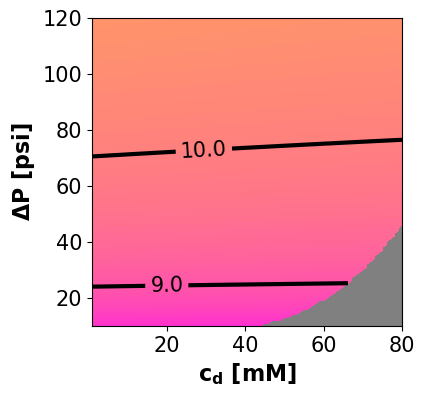

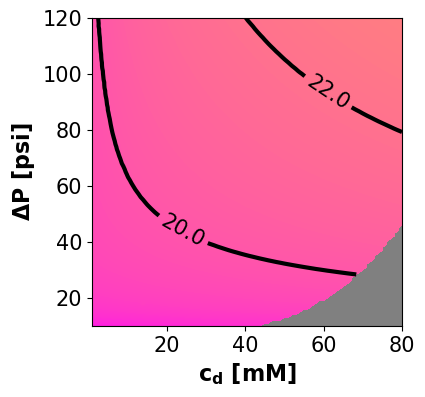

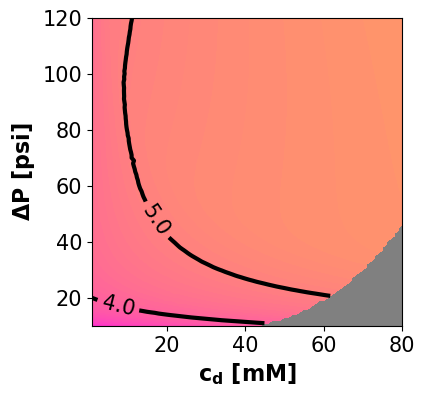

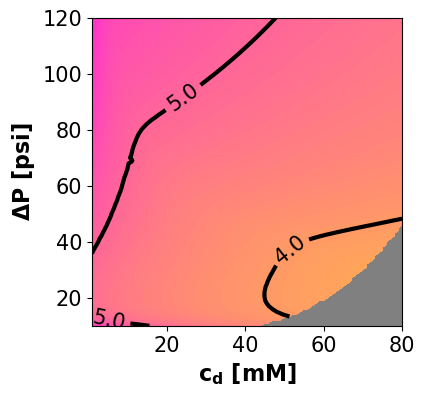

In [6]:
data_stru_d = loadmat('data\\data_stru-dataset511.12.mat')['data_stru']
heatmap_doe_stru = loadmat('data\\heatmap_doe-dat511.12-endvial1.mat')['heatmap_doe']

Vmin = [7,14,1,2]
Vmax = [13,32,9,7]
Level = [[9,10],
         [20,22],
         [4,5],
         [4,5]]
Manual_locations = [[(20,30),(30,60)],
                   [(30,60),(55,80)],
                   [(10,30),(20,50)],
                   [(5,10),(30,80),(50,40)]]
Colorbar_ticks = [0, 1, 2, 3]
name_append = '-endvial1'
plot_heatmap_doe_FIM(data_stru_d, heatmap_doe_stru, Vmin, Vmax, Level, Colorbar_ticks, Manual_locations, name_append, filled =True)

C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:15: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:29: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:45: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):


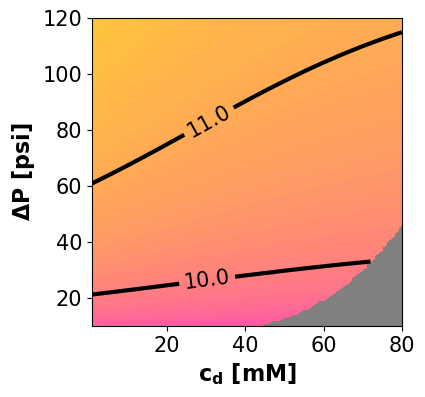

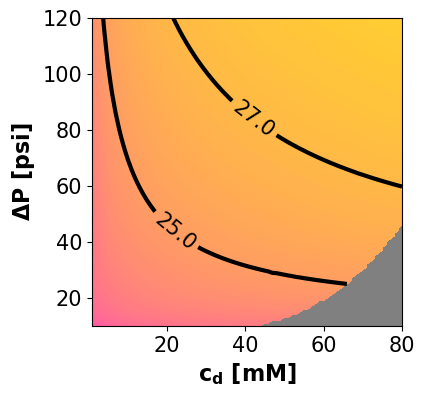

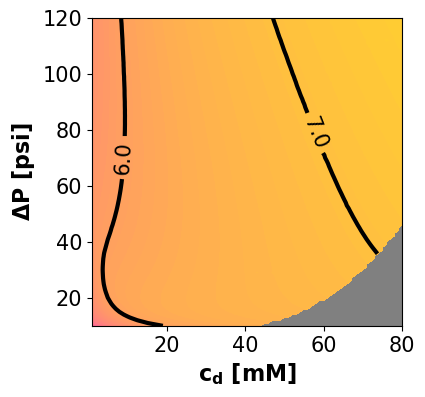

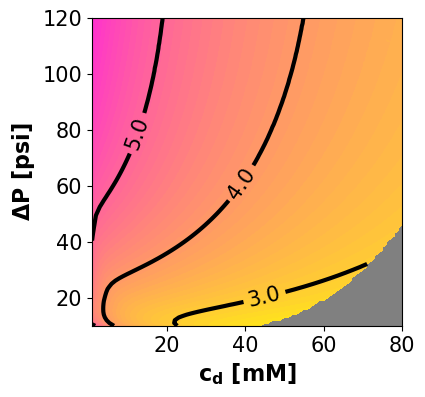

In [7]:
data_stru_d = loadmat('data\\data_stru-dataset511.12.mat')['data_stru']
heatmap_doe_stru = loadmat('data\\heatmap_doe-dat511.12-endvial5.mat')['heatmap_doe']

Vmin = [7,14,1,2]
Vmax = [13,32,9,7]
Level = [[10,11],
         [25,27],
         [6,7],
         [3,4,5]]
Manual_locations = [[(30,30),(40,60)],
                   [(20,40),(40,80)],
                   [(10,70),(60,80)],
                   [(10,80),(40,60),(45,20)]]
Colorbar_ticks = [0, 1, 2, 3]
name_append = '-endvial5'
plot_heatmap_doe_FIM(data_stru_d, heatmap_doe_stru, Vmin, Vmax, Level, Colorbar_ticks, Manual_locations, name_append, filled =True)

C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:15: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(d[key], spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:29: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(elem, spio.matlab.mio5_params.mat_struct):
C:\Users\dany2\AppData\Local\Temp\ipykernel_8220\1078908036.py:45: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(sub_elem, spio.matlab.mio5_params.mat_struct):


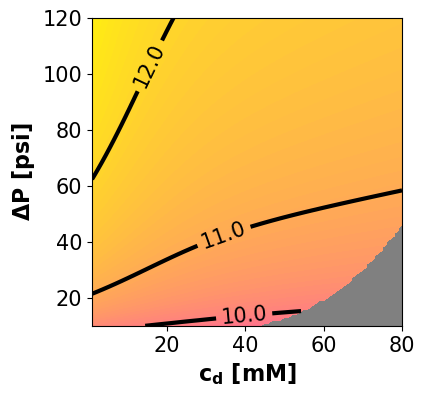

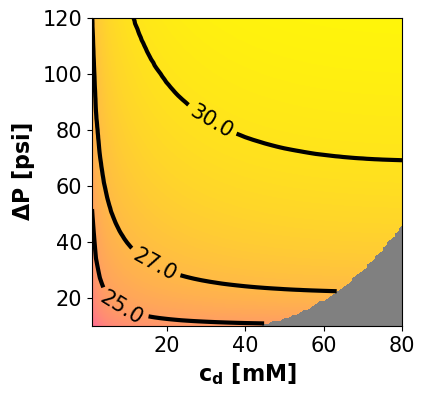

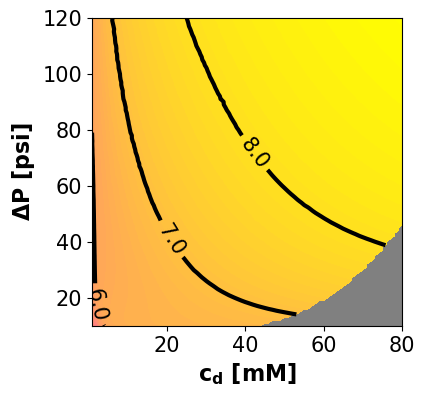

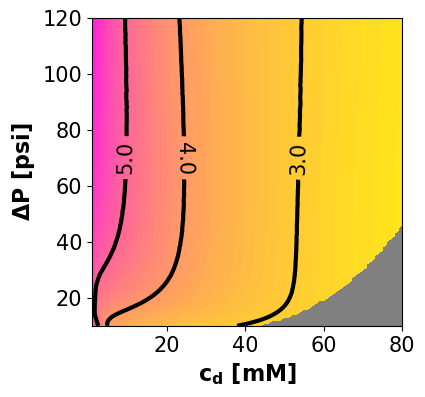

In [8]:
data_stru_d = loadmat('data\\data_stru-dataset511.12.mat')['data_stru']
heatmap_doe_stru = loadmat('data\\heatmap_doe-dat511.12-endvial10.mat')['heatmap_doe']

Vmin = [7,14,1,2]
Vmax = [13,32,9,7]
Level = [[10,11,12],
         [25,27,30],
         [6,7,8],
         [3,4,5]]
Manual_locations = [[(40,10),(30,60),(20,100)],
                   [(10,20),(20,40),(30,80)],
                   [(10,20),(20,40),(50,80)],
                   [(50,70),(20,70),(10,70)]]
Colorbar_ticks = [0, 1, 2, 3]
name_append = '-endvial10'
plot_heatmap_doe_FIM(data_stru_d, heatmap_doe_stru, Vmin, Vmax, Level, Colorbar_ticks, Manual_locations, name_append, filled =True)